# CMS GIWAXS plotting notebook

In [125]:
### Kernel updates:

# !pip install pyhyperscattering  # to use pip published package
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory
!pip install tifftools

Obtaining file:///nsls2/users/alevin/repos/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0+untagged.493.g05951d0-0.editable-py3-none-any.whl size=5438 sha256=e1777375c801cafc7785d0401467fa6a6ba6b15eddaf5a4109c471fd00c36dea
  Stored in directory: /tmp/pip-ephem-wheel-cache-k7q97r1q/wheels/7d/89/c7/db1d0cb1cf714f3a03a438abee7b78ce09921efd15259b1f5f
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0+untagged.493.g05951d0
    Uninstalling PyHyperScattering-0+untagged.493.g05951d0:
      Successfully uninstalled PyHyperScattering-0+untagged.493.g05951d0


## Restart Kernel! Next, imports & defining paths

In [1]:
## The autoreload IPython magic command reloads all modules before code is ran
%load_ext autoreload

In [ ]:
%autoreload
# phs.load.CMSGIWAXSLoader??
# phs.util.GIWAXS??

In [71]:
### Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import PyHyperScattering as phs
from PIL import Image  # Using this to load TIFFs as that is what is done in SST1RSoXSLoader.py, instead of fabio
import tifftools
import dask.array as da

import pyFAI
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration
import pygix

print(f'Using PyHyperScattering Version: {phs.__version__}')
print(f"Using pyFAI version {pyFAI.version}")

cmap = plt.cm.turbo
cmap.set_bad('black')

pg_convert = phs.util.GIWAXS.pg_convert
pg_convert_series = phs.util.GIWAXS.pg_convert_series

Using PyHyperScattering Version: 0+untagged.493.g05951d0
Using pyFAI version 2023.5.0


In [3]:
### Define paths:
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')
dataPath = propPath.joinpath('KWhite5')
calibPath = dataPath.joinpath('maxs/raw/LaB6_5.6m_12.7keV_4250.1s_x0.001_th0.120_10.00s_1118442_maxs.tiff')
maskPath = userPath.joinpath('giwaxs_suite/beamline_data/masks')
savePath = propPath.joinpath('processed_data')

In [123]:
dataPath

PosixPath('/nsls2/data/cms/proposals/2023-2/pass-311415/KWhite5')

In [4]:
sorted([f.name for f in dataPath.iterdir()])

['data',
 'maxs',
 'pm6_misc_cb_002',
 'pm6_misc_cb_18_100_22_80_75_006',
 'pm6_misc_cb_18_200_22_80_75_002',
 'pm6_misc_cb_18_200_22_80_75_003',
 'pm6_misc_cb_18_200_22_80_75_004',
 'pm6_misc_cb_18_200_30_80_75_007',
 'pm6_misc_cb_18_300_22_80_75_005',
 'pm6_misc_cb_18mgpml_200um_22mmps_sol80C_stg75C_001',
 'pm7_S1_95tol5cpme_14_100_18_85_75_009',
 'pm7_S1_95tol5cpme_14_100_22p7_85_75_008',
 'pm7_S1_95tol5cpme_14_100_26_85_75_010',
 'pm7_S1_95tol5cpme_14_200_22p7_85_75_008',
 'pybtz_CBCNp1_15_200_40_60_60_013',
 'pybtz_CBCNp5_15_200_40_60_60_014',
 'pybtz_CB_15_200_40_60_60_011',
 'pybtz_CB_15_200_40_60_60_012',
 'sam1_p3ht_toluene',
 'sam2_p3ht_toluene',
 'sam3_p3ht_toluene',
 'saxs',
 'test',
 'user_bladecoater.py',
 'waxs']

## Load selected samples & files

In [59]:
sample = 'pybtz_CB_15_200_40_60_60_011'
samplePath = dataPath.joinpath(sample, 'maxs/raw')
sorted([f.name for f in samplePath.glob('*')])

['pybtz_CB_15_200_40_60_60_011_1055.8s_x-0.000_th0.120_2.00s_1117892_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000000_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000001_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000002_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000003_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000004_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000005_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000006_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000007_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000008_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_x-0.000_th0.120_0.10s_1117893_000009_maxs.tiff',
 'pybtz_CB_15_200_40_60_60_011_1193.8s_

In [9]:
### Metadata filename naming schemes:
# For nonrotated, qpara images:
standard_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'time_start',
                    'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# For rotated, qperp images:
qperp_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'in-plane_orientation',
                    'time_start', 'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# For in situ series images:
in_situ_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'time_start',
                    'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 
                    'series_number', 'detector']

In [10]:
loader = phs.load.CMSGIWAXSLoader()  # empty md naming scheme
standard_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=standard_md_naming_scheme)
qperp_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=qperp_md_naming_scheme)
series_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=in_situ_md_naming_scheme)

### Single image loading

#### qperp

In [ ]:
DA = qperp_loader.loadSingleImage(samplePath.joinpath('pybtz_CBCNp1_15_200_40_60_60_013_qperp_1552.0s_x2.001_th0.120_5.00s_1118314_maxs.tiff'))

In [ ]:
recip_DA, caked_DA = pg_convert(DA, poniFile, maskFile, inplane_config='q_perp')

In [ ]:
ax = recip_DA.sel(q_para=slice(-2, 1), q_z=slice(-0.01, 2)).plot.imshow(norm=LogNorm(4e1, 2.5e3), cmap=plt.cm.turbo, interpolation='antialiased')
ax.axes.set(aspect='equal', xlabel='$q_{perp}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'1% CN, 5 s exposure, 0.12° incident angle')
ax.figure.set(size_inches=(7,3.5), tight_layout=True)
plt.show()
ax.figure.savefig(savePath.joinpath(f'{recip_da.material}_{recip_da.solvent}_qperp_{recip_da.incident_angle}_{recip_da.exposure_time}_{recip_da.scan_id}.png'), dpi=120)
plt.close('all')

#### qpara

In [60]:
DA = standard_loader.loadSingleImage(samplePath.joinpath('pybtz_CB_15_200_40_60_60_011_1846.1s_x-0.002_th0.120_5.00s_1117968_maxs.tiff'))

In [79]:
recip_DA, caked_DA = pg_convert(DA, poniFile, maskFile, inplane_config='q_para')

In [80]:
recip_DA

<xarray.DataArray (q_z: 1043, q_para: 981)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * q_z      (q_z) float64 -1.883 -1.878 -1.874 -1.869 ... 2.965 2.969 2.974
  * q_para   (q_para) float64 -2.479 -2.475 -2.47 -2.465 ... 2.232 2.237 2.242
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            1846.1s
    x_position_offset:     x-0.002
    incident_angle:        th0.120
    exposure_time:         5.00s
    scan_id:               1117968
    detector:              maxs.tiff

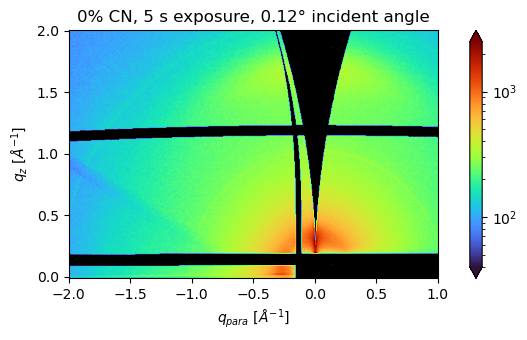

In [82]:
ax = recip_DA.sel(q_para=slice(-2, 1), q_z=slice(-0.01, 2)).plot.imshow(norm=LogNorm(4e1, 2.5e3), cmap=plt.cm.turbo, interpolation='antialiased')
ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'0% CN, 5 s exposure, 0.12° incident angle')
ax.figure.set(size_inches=(7,3.5), tight_layout=True)
plt.show()
# ax.figure.savefig(savePath.joinpath(f'{recip_DA.material}_{recip_DA.solvent}_{recip_DA.incident_angle}_{recip_DA.exposure_time}_{recip_DA.scan_id}.png'), dpi=120)
plt.close('all')

### Image series loading

In [11]:
pybtz_CB_0to10s_series = series_loader.loadSeries(samplePath, '1118024')
pybtz_CB_0to10s_series

<xarray.DataArray (time: 100, pix_y: 1043, pix_x: 981)>
array([[[ 0,  1,  0, ...,  1,  0,  0],
        [ 1,  1,  0, ...,  2,  0,  1],
        [ 0,  0,  1, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 1,  1,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]],

       [[ 0,  1,  0, ...,  0,  1,  0],
        [ 1,  0,  0, ...,  1,  2,  1],
        [ 0,  0,  0, ...,  1,  0,  0],
        ...,
        [ 1,  1,  0, ..., -2, -2, -2],
        [ 1,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  1, ..., -2, -2, -2]],

       [[ 1,  1,  0, ...,  0,  1,  0],
        [ 1,  0,  2, ...,  3,  1,  1],
        [ 0,  0,  0, ...,  2,  0,  1],
        ...,
...
        ...,
        [ 1,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]],

       [[ 0,  1,  1, ...,  1,  0,  1],
        [ 1,  1,  2, ...,  0,  1,  1],
        [ 1,  2,  0, ...,  1,  0,  1],
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 1,  1,  0, ..., -2, -2, -2],
        [ 0,  1,  1, ..., -2, -2, -2]],

       [[ 0,  1,  1, ...,  1,  1,  0],
        [ 0,  2,  0, ...,  1,  0,  0],
        [ 1,  0,  1, ...,  2,  1,  0],
        ...,
        [ 0,  0,  0, ..., -2, -2, -2],
        [ 1,  1,  1, ..., -2, -2, -2],
        [ 0,  0,  0, ..., -2, -2, -2]]], dtype=int32)
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time           (time) float64 0.1 0.2 0.3 0.4 0.5 ... 9.6 9.7 9.8 9.9 10.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            329.6s
    x_position_offset:     x0.001
    incident_angle:        th0.120
    exposure_time:         0.10s
    scan_id:               1118024
    detector:              maxs.tiff

In [12]:
pybtz_CB_10to90s_series = series_loader.loadSeries(samplePath, '1118025', time_start=10)
pybtz_CB_10to90s_series

<xarray.DataArray (time: 160, pix_y: 1043, pix_x: 981)>
array([[[ 4,  1,  3, ...,  4,  3,  5],
        [ 2,  2,  4, ...,  4,  2,  5],
        [ 5,  2,  1, ...,  0,  5,  8],
        ...,
        [ 2,  3,  5, ..., -2, -2, -2],
        [ 2,  0,  1, ..., -2, -2, -2],
        [ 0,  0,  1, ..., -2, -2, -2]],

       [[ 4,  3,  3, ...,  5,  5,  3],
        [ 3,  2,  4, ...,  3,  5,  5],
        [ 3,  3,  4, ...,  9,  9,  5],
        ...,
        [ 2,  2,  0, ..., -2, -2, -2],
        [ 1,  0,  1, ..., -2, -2, -2],
        [ 0,  1,  1, ..., -2, -2, -2]],

       [[ 3,  2,  3, ...,  5,  4,  3],
        [ 4,  4,  4, ...,  4,  4,  2],
        [ 5,  3,  3, ...,  6,  5,  4],
        ...,
...
        ...,
        [ 2,  1,  0, ..., -2, -2, -2],
        [ 0,  3,  1, ..., -2, -2, -2],
        [ 1,  1,  2, ..., -2, -2, -2]],

       [[ 3,  4,  2, ...,  3,  5,  4],
        [ 4,  5,  3, ...,  4,  4,  4],
        [ 2,  3,  4, ...,  4,  5,  5],
        ...,
        [ 0,  1,  2, ..., -2, -2, -2],
        [ 2,  1,  2, ..., -2, -2, -2],
        [ 1,  1,  1, ..., -2, -2, -2]],

       [[ 4,  4,  4, ...,  4,  1,  5],
        [ 3,  6,  4, ...,  4,  6,  4],
        [ 4,  3,  6, ...,  4,  6,  3],
        ...,
        [ 1,  1,  1, ..., -2, -2, -2],
        [ 1,  2,  2, ..., -2, -2, -2],
        [ 1,  0,  1, ..., -2, -2, -2]]], dtype=int32)
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
  * time           (time) float64 10.5 11.0 11.5 12.0 ... 88.5 89.0 89.5 90.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            412.6s
    x_position_offset:     x0.001
    incident_angle:        th0.120
    exposure_time:         0.49s
    scan_id:               1118025
    detector:              maxs.tiff

In [13]:
pybtz_CB_90to180s_series = series_loader.loadSeries(samplePath, '1118026', time_start=90)
pybtz_CB_90to180s_series

<xarray.DataArray (time: 45, pix_y: 1043, pix_x: 981)>
array([[[15, 18, 16, ..., 14, 21, 13],
        [15, 10, 14, ..., 16, 18, 12],
        [14, 16, 16, ..., 26, 18, 16],
        ...,
        [ 3,  3,  9, ..., -2, -2, -2],
        [ 4,  6,  3, ..., -2, -2, -2],
        [ 3,  7,  4, ..., -2, -2, -2]],

       [[13, 15, 12, ..., 20, 17, 13],
        [14, 17, 13, ..., 21, 21,  8],
        [13, 15, 16, ..., 25, 12, 20],
        ...,
        [ 4,  6,  5, ..., -2, -2, -2],
        [ 6,  3,  3, ..., -2, -2, -2],
        [ 5,  5,  6, ..., -2, -2, -2]],

       [[13, 18, 15, ..., 21, 13, 20],
        [14, 15, 15, ..., 22, 15, 17],
        [16, 19, 19, ..., 19, 19, 14],
        ...,
...
        ...,
        [ 4,  6,  7, ..., -2, -2, -2],
        [ 6,  3,  6, ..., -2, -2, -2],
        [ 4,  7,  5, ..., -2, -2, -2]],

       [[10, 17, 12, ..., 10, 14, 15],
        [ 9, 15, 15, ..., 14, 22, 17],
        [12, 25, 21, ..., 18, 17, 18],
        ...,
        [ 2,  8,  4, ..., -2, -2, -2],
        [ 3,  6,  5, ..., -2, -2, -2],
        [ 5,  5,  6, ..., -2, -2, -2]],

       [[15, 17, 19, ..., 22, 14, 12],
        [11, 20, 19, ..., 18, 19, 13],
        [17, 18, 18, ..., 23, 17, 14],
        ...,
        [ 5,  7,  4, ..., -2, -2, -2],
        [ 3,  7,  5, ..., -2, -2, -2],
        [ 3,  8,  2, ..., -2, -2, -2]]], dtype=int32)
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 8 ... 36 37 38 39 40 41 42 43 44
  * time           (time) float64 92.0 94.0 96.0 98.0 ... 176.0 178.0 180.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            507.0s
    x_position_offset:     x0.001
    incident_angle:        th0.120
    exposure_time:         2.00s
    scan_id:               1118026
    detector:              maxs.tiff

In [119]:
np_arr = pybtz_CB_0to10s_series.data
dask_arr = da.from_array(np_arr, chunks=(np_arr.shape[0]/10, np_arr.shape[1], np_arr.shape[2]))
dask_DA = pybtz_CB_0to10s_series.copy()
dask_DA.data = dask_arr
dask_DA

<xarray.DataArray (time: 100, pix_y: 1043, pix_x: 981)>
dask.array<array, shape=(100, 1043, 981), dtype=int32, chunksize=(10, 1043, 981), chunktype=numpy.ndarray>
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time           (time) float64 0.1 0.2 0.3 0.4 0.5 ... 9.6 9.7 9.8 9.9 10.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            329.6s
    x_position_offset:     x0.001
    incident_angle:        th0.120
    exposure_time:         0.10s
    scan_id:               1118024
    detector:              maxs.tiff

In [109]:
ds = dask_DA.to_dataset(name='pybtz_CB_0to10s_series_dask')
ds.to_zarr('test.zarr', mode='w')

In [118]:
ds_loaded = xr.open_zarr('test.zarr')
DA_loaded = ds_loaded.pybtz_CB_0to10s_series_dask
DA_loaded

<xarray.DataArray 'pybtz_CB_0to10s_series_dask' (time: 100, pix_y: 1043,
                                                 pix_x: 981)>
dask.array<open_dataset-pybtz_CB_0to10s_series_dask, shape=(100, 1043, 981), dtype=int32, chunksize=(10, 1043, 981), chunktype=numpy.ndarray>
Coordinates:
  * pix_x          (pix_x) int64 0 1 2 3 4 5 6 7 ... 974 975 976 977 978 979 980
  * pix_y          (pix_y) int64 0 1 2 3 4 5 6 ... 1037 1038 1039 1040 1041 1042
    series_number  (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
  * time           (time) float64 0.1 0.2 0.3 0.4 0.5 ... 9.6 9.7 9.8 9.9 10.0
Attributes: (12/14)
    blade_speed:           40
    concentration:         15
    detector:              maxs.tiff
    exposure_time:         0.10s
    gap_height:            200
    incident_angle:        th0.120
    ...                    ...
    scan_id:               1118024
    solution_temperature:  60
    solvent:               CB
    stage_temperature:     60
    time_start:            329.6s
    x_position_offset:     x0.001

## Data transformations

### Draw mask if needed:

In [ ]:
# ### Load calibration file, draw mask via PyHyper

# LaB6_da = loader.loadSingleImage(calibPath)
# print(calibPath.name)
# print('ENERGY WAS  13.5 keV, NOT 12.7 keV!!')
# # ax = LaB6_da.plot(norm=LogNorm(6e1, 1e3), cmap=plt.cm.viridis, figsize=(6,3))
# # ax.axes.set_aspect('equal')
# # plt.show()
# draw = phs.IntegrationUtils.DrawMask(LaB6_da)
# draw.ui()

In [ ]:
# ### Save drawn mask above, optionally plot it

# draw.save(userPath.joinpath('LaB6.json'))
# # draw.load(maskPath.joinpath('LaB6.json'))
# mask = draw.mask  # Loads mask as numpy array
# fig, ax = plt.subplots(figsize=(6,6))
# ax.imshow(mask, origin='lower', aspect='equal')
# ax.set(ylabel='pix_y', xlabel='pix_x')
# plt.show()

### Run pyFAI calibration if needed:

In [ ]:
# %matplotlib widget

# ### Open & run calibration widget
# LaB6_da = loader.loadSingleImage(calibPath)  # This is needed if you did not execute the above cells for masking
# wavelength = 9.18e-11  # Important to be correct!
# pilatus = pyFAI.detector_factory('Pilatus1M')
# LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
# LaB6.wavelength = wavelength

# calib = Calibration(LaB6_da.data, calibrant=LaB6, wavelength=wavelength, detector=pilatus)

In [ ]:
# ### Check & save .poni
# gr = calib.geoRef
# print(gr)
# print(calib.fixed)
# print(gr.chi2())
# gr.save(maskPath.joinpath('LaB6.poni'))

In [ ]:
# # Optional fit with rotations fixed to 0
# # Likely the best fit for transmission geometry
# gr = calib.geoRef
# gr.rot1=gr.rot2=gr.rot3=0
# # gr.center_array=[318, 1277]
# # gr.set_dist = 2.837
# gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3'])
# print(gr.chi2())
# print(gr)
# gr.save(maskPath.joinpath('LaB6_fixed_rot.poni'))

In [ ]:
# %matplotlib inline
# # This verifies that the calibration is good (overlays expected calibrant peaks with reduced data)
# # azimuthal integrator tool in pyFAI for transmission mode (use pygix for GI geometry)

# ai = pyFAI.load(str(maskPath.joinpath('LaB6_fixed_rot.poni'))) # load the .poni calibration file into azimuthal integrator

# res1 = ai.integrate1d(LaB6_da.data, 1000) #circular integration
# res2 = ai.integrate2d(LaB6_da.data, 1000) #makes caked 2d image (q vs chi)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set(size_inches=(10,4))
# jupyter.plot1d(res1, ax=ax1, calibrant=LaB6)
# jupyter.plot2d(res2, ax=ax2, calibrant=LaB6)
# ax2.set_title('2D cake')
# plt.tight_layout()

In [ ]:
# recip_da, caked_da = pg_convert(da=pybtz_CB_90to180s_series.sel(time=100),
#                            poniPath=maskPath.joinpath('LaB6_fixed_rot.poni'),
#                            maskPath=maskPath.joinpath('LaB6.json'), inplane_config='q_para')

In [ ]:
# ax = recip_da.sel(time=100, q_z=slice(-0.05,2), q_para=slice(-2, 2)).plot.imshow(cmap=cmap, norm=LogNorm(2e1, 1e3), 
#                                                                        figsize=(10,4), interpolation='antialiased')
# ax.axes.set_aspect('equal')

In [ ]:
# def pg_convert_series(da, poniPath, maskPath, inplane_config='q_xy'):
#     recip_das = []
#     caked_das = []
#     for time in da.time:
#         da_slice = da.sel(time=float(time))
#         recip_da_slice, caked_da_slice = pg_convert(da=da_slice, 
#                                                     poniPath=poniPath,
#                                                     maskPath=maskPath,
#                                                     inplane_config=inplane_config)
#         recip_das.append(recip_da_slice)
#         caked_das.append(caked_da_slice)
        
#     recip_da_series = xr.concat(recip_das, 'time')
#     caked_da_series = xr.concat(caked_das, 'time')
    
#     return recip_da_series, caked_da_series


### Convert DataArrays

In [40]:
poniFile=maskPath.joinpath('LaB6_fixed_rot.poni')
maskFile=maskPath.joinpath('LaB6.json')
# recip_pybtz_CB_100, caked_pybtz_CB_100 = pg_convert(pybtz_CB_90to180s_series.sel(time=100), poniFile, maskFile)

In [43]:
recip_pybtz_CB_0to10s_series, caked_pybtz_CB_0to10s_series = pg_convert_series(da=pybtz_CB_0to10s_series,
                                                                                 poniPath=poniFile,
                                                                                 maskPath=maskFile, inplane_config='q_para')

In [44]:
recip_pybtz_CB_10to90s_series, caked_pybtz_CB_10to90s_series = pg_convert_series(da=pybtz_CB_10to90s_series,
                                                                                  poniPath=poniFile,
                                                                                  maskPath=maskFile, inplane_config='q_para')

In [45]:
recip_pybtz_CB_90to180s_series, caked_pybtz_CB_90to180s_series = pg_convert_series(da=pybtz_CB_90to180s_series,
                                                                                   poniPath=poniFile,
                                                                                   maskPath=maskFile, inplane_config='q_para')

In [47]:
display(recip_pybtz_CB_0to10s_series, caked_pybtz_CB_0to10s_series)

<xarray.DataArray (time: 100, q_z: 1043, q_para: 981)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * q_z      (q_z) float64 -1.883 -1.878 -1.874 -1.869 ... 2.965 2.969 2.974
  * q_para   (q_para) float64 -2.479 -2.475 -2.47 -2.465 ... 2.232 2.237 2.242
  * time     (time) float64 0.1 0.2 0.3 0.4 0.5 0.6 ... 9.5 9.6 9.7 9.8 9.9 10.0
Attributes: (12/14)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    time_start:            329.6s
    x_position_offset:     x0.001
    incident_angle:        th0.120
    exposure_time:         0.10s
    scan_id:               1118024
    detector:              maxs.tiff

<xarray.DataArray (time: 100, chi: 180, qr: 1000)>
array([[[ 8.53902  , 10.362035 , 11.520256 , ...,  0.       ,
          0.       ,  0.       ],
        [ 7.006588 , 10.972155 , 14.499535 , ...,  0.       ,
          0.       ,  0.       ],
        [ 8.60284  ,  8.322533 ,  9.069837 , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 8.414927 ,  9.365049 , 11.230267 , ...,  0.       ,
          0.       ,  0.       ],
        [13.012235 ,  9.613783 ,  8.463367 , ...,  0.       ,
          0.       ,  0.       ],
        [11.416017 ,  9.982647 , 10.146818 , ...,  0.       ,
          0.       ,  0.       ],
...
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 4.17644  , 10.711274 , 14.792982 , ...,  0.       ,
          0.       ,  0.       ],
        [ 8.007529 ,  8.007784 ,  8.493494 , ...,  0.       ,
          0.       ,  0.       ],
        [ 7.209422 ,  8.060242 ,  8.806406 , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.1706 0.1741 0.1777 0.1812 ... 3.719 3.722 3.726
  * time     (time) float64 0.1 0.2 0.3 0.4 0.5 0.6 ... 9.5 9.6 9.7 9.8 9.9 10.0
Attributes: (12/15)
    material:              pybtz
    solvent:               CB
    concentration:         15
    gap_height:            200
    blade_speed:           40
    solution_temperature:  60
    ...                    ...
    x_position_offset:     x0.001
    incident_angle:        th0.120
    exposure_time:         0.10s
    scan_id:               1118024
    detector:              maxs.tiff
    inplane_config:        q_para

## Plotting

In [49]:
### Define color limits acceptable for the different exposure times
recip_vlims = {
    recip_pybtz_CB_0to10s_series.exposure_time: (0.8, 4e1),
    recip_pybtz_CB_10to90s_series.exposure_time: (4, 2e2),
    recip_pybtz_CB_90to180s_series.exposure_time: (3e1, 1e3)
}

### Select 2D Plot

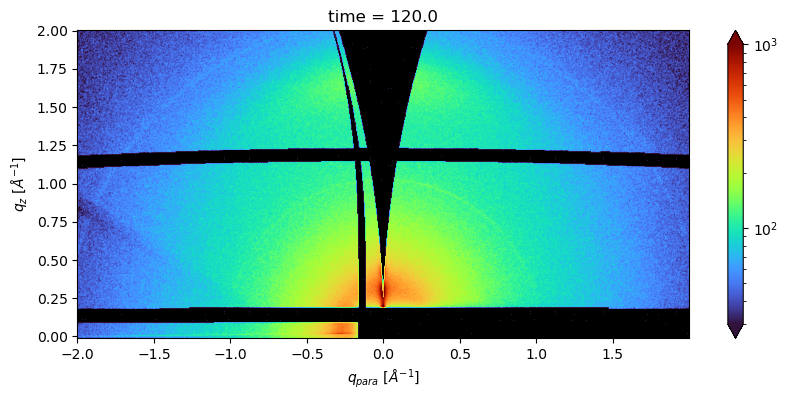

In [129]:
ax = recip_pybtz_CB_90to180s_series.sel(time=120, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(3e1, 1e3), figsize=(10,4), interpolation='antialiased')
ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$')
plt.show()

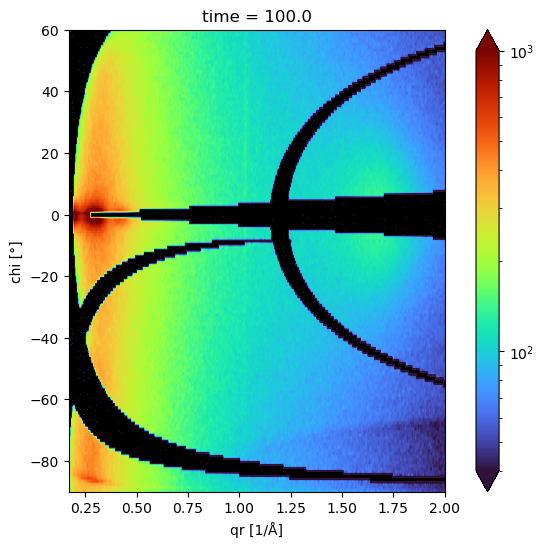

In [133]:
ax = caked_pybtz_CB_90to180s_series.sel(time=100, qr=slice(0,2), chi=slice(-90, 60)).plot.imshow(cmap=cmap, norm=LogNorm(4e1, 1e3), figsize=(8,6), interpolation='antialiased')
ax.axes.set(aspect=1.5e-2)
plt.show()

AttributeError: QuadMesh.set() got an unexpected keyword argument 'col_size'

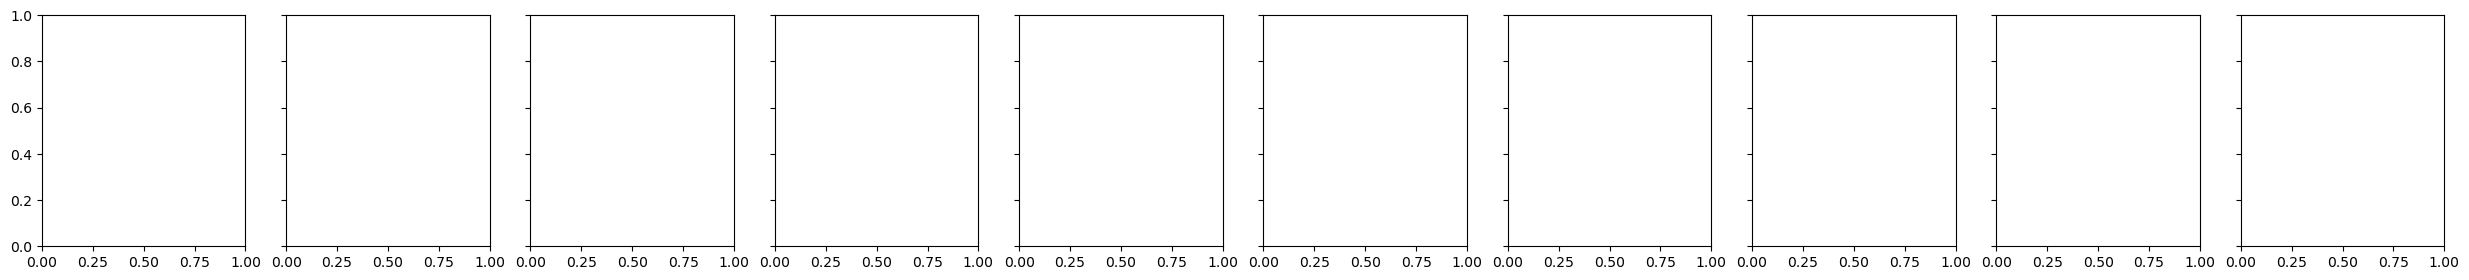

In [146]:
caked_pybtz_CB_0to10s_series.sel(time=slice(0,1)).plot(col='time', col_size=4)

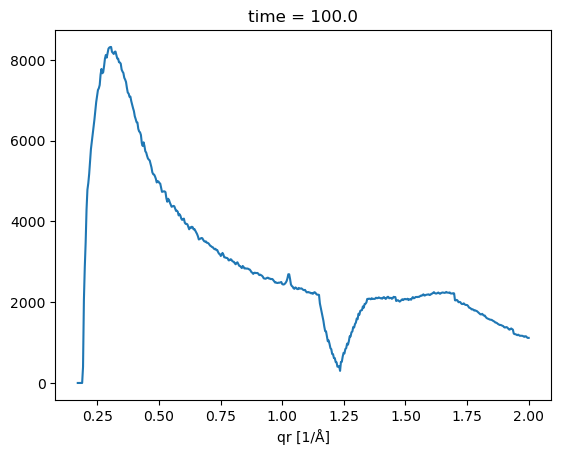

In [139]:
caked_pybtz_CB_90to180s_series.sel(time=100, qr=slice(0,2), chi=slice(5,25)).sum('chi').plot()

### Generate & Save TIFF plot stacks

In [ ]:
sample

In [ ]:
### Saves tiff images for all time slices
for da in (recip_pybtz_CBCNp1_0to10s_series, recip_pybtz_CBCNp1_10to90s_series, recip_pybtz_CBCNp1_90to180s_series):
    vlim = recip_vlims[da.exposure_time]
    for time in da.time:
        time = np.round(float(time), 1)
        ax = da.sel(time=time, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(vlim[0], vlim[1]), figsize=(10,4), interpolation='antialiased')
        ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'PY-BTz BHJ in CB, 1% CN; Time = {time} s')
        # plt.show()
        ax.figure.set_tight_layout(True)
        ax.figure.savefig(savePath.joinpath(f'single_tiffs/{sample}_time-{time}.tiff'), dpi=120)
        plt.close('all')

In [ ]:
### Stack tiff frames

framePaths = sorted(savePath.joinpath('single_tiffs').glob(f'{sample}*'), key=lambda x: float(str(x).split('-')[-1][:-5]))
frame1 = tifftools.read_tiff(framePaths[0])
for framePath in framePaths[1:]:
    frame = tifftools.read_tiff(framePath)
    frame1['ifds'].extend(frame['ifds'])
tifftools.write_tiff(frame1, savePath.joinpath(f'tiff_stacks/recip_{sample}.tiff'), allowExisting=True)
    